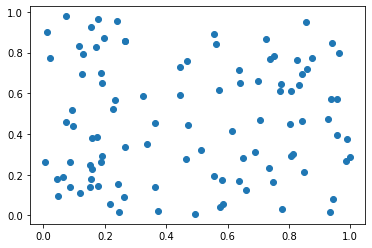

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

N = 100
pts = np.random.random((N,2))

plt.scatter(pts[:,0], pts[:,1])

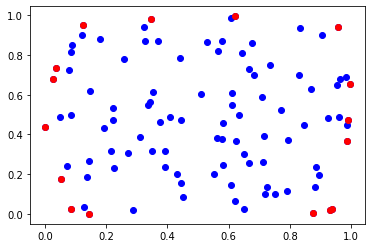

In [67]:
def scatt(pts, c='blue'):
    pts = np.array(pts)
    if len(pts) > 0:
        plt.scatter(pts[:,0], pts[:,1], c=c)

def dist(p, A, B):
    return norm(np.cross(B-A, A-p))/norm(B-A)

def side(pt, A, B):
    return ((pt[0]-A[0])*(B[1]-A[1])-(pt[1]-A[1])*(B[0]-A[0])) < 0

def same(p1, p2):
    return p1[0] == p2[0] and p1[1] == p2[1]

def partition_set(pts, A, B):
    set_A = []
    set_B = []
    for pt in pts:
        if not same(pt, A) and not same(pt, B):
            if side(pt, A, B):
                set_A.append(pt)
            else:
                set_B.append(pt)
    return np.array(set_A), np.array(set_B)

def findhull(pts, P, Q):
    if len(pts) == 0:
        return []
    d_p = lambda pt : dist(pt, P, Q)
    m = np.argmax(list(map(d_p, pts)))
    c = pts[m]
    hull = [c]
    np.delete(pts, m)
    S1, S0 = partition_set(pts, P, c)
    S2, S0 = partition_set(S0 , c, Q)

    hull += findhull(S1, P, c)
    hull += findhull(S2, c, Q)  
    return hull

    

def quickhull(pts):
    hull = []
    l = min(pts, key=lambda p : p[0])
    r = max(pts, key=lambda p : p[0])
    hull += [l, r]
    
    ls, rs = partition_set(pts, l, r)
    hull += findhull(ls, l, r)
    hull += findhull(rs, r, l)
    
    return hull

hull = quickhull(pts)
scatt(pts)
scatt(hull, c='red')


12
2.1213203435596424


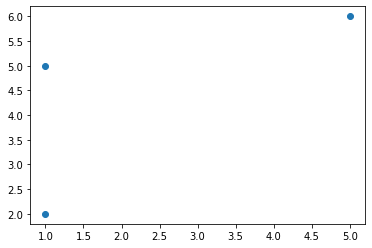

In [15]:
pts = np.array([[1, 5], [1,2],[5,6]])

A = (1, 5)
B = (1, 2)
C = (5, 6)

def dist(A,B,C):
    tp = np.abs((C[0] - B[0]) * (B[1] - A[1]) - (B[0] - A[0]) * (C[1] - B[1]))
    print(tp)
    bt = np.sqrt((C[0] - B[0]) ** 2 + (C[1] - B[1]) ** 2)
    return tp/bt
    
print(dist(A,B,C))
plt.scatter(pts[:,0],pts[:,1])

In [8]:
def graph(name, filename, arr):
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    ax1, ax2, ax3 = axes
    [ax.set_xticks(np.arange(arr.shape[0])) for ax in axes]
    
    ranks = [2**n for n in range(0,7)]
    pts = [f'2^{x}' for x in range(24,31)]
    pts_exp = [2**x for x in range(24,31)]
    
    ax1.set_xticklabels(pts)
    ax1.set_xlabel("Number of Points")
    ax1.set_ylabel("Time to Compute (sec)")
    ax1.set_title(f"{name} Performance")
    ax1.plot(arr)
    rank_labels = [f'1 node, {r} rank{"s" if r != 1 else ""}' for r in ranks]
    rank_labels[-1] = '2 nodes, 32 ranks'
    ax1.legend(rank_labels)

    ax2.set_xticklabels(ranks)
    ax2.set_xlabel("Number of Processors")
    ax2.set_ylabel("Time to Compute (sec)")
    ax2.set_title(f"Weak Scaling of {name}")
    for i in range(-1,2):
        ax2.plot(np.diag(arr, k=i))
    ax2.legend(["2^25 pts/processor","2^24 pts/processor","2^23 pts/processor"])

    ax3.set_xticklabels(ranks)
    ax3.set_xlabel("Number of Processors")
    ax3.set_ylabel("Speed-up (1.0x = 1 processor)")
    ax3.set_title(f"Strong Scaling of {name}")
    for t in arr:
        if np.isnan(t[0]):
            t[0] = 2*t[1]
        ax3.plot(t[0]/t)
    ax3.legend([f'{p} points' for p in pts])


    plt.savefig(filename)
    plt.show()

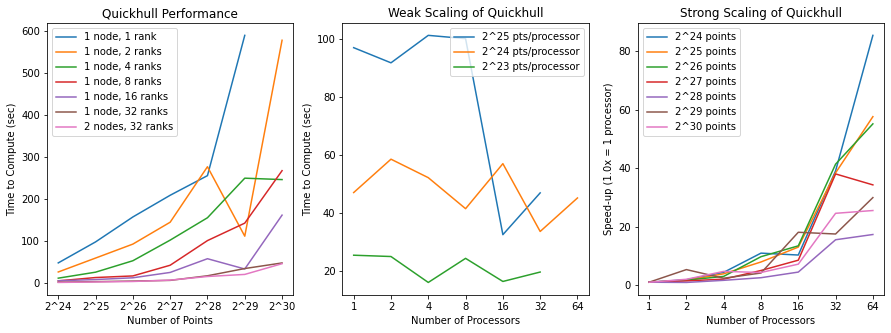

In [88]:
f = open("quick_results.txt", "r")
res = []
for x in f:
    res.append(float(x))
arr = np.array(res).reshape(7,7)

graph('Quickhull', 'qh_performance.png', arr)

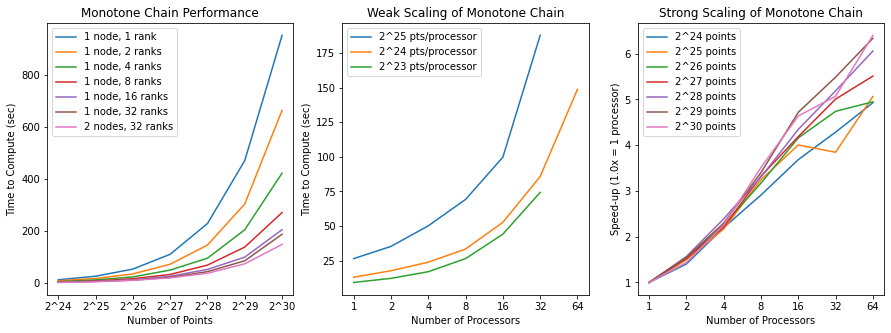

In [78]:
f = open("mc_results.txt", "r")
res = []
for x in f:
    res.append(float(x))
arr = np.array(res).reshape(7,7)

graph('Monotone Chain', 'mc_performance.png', arr)

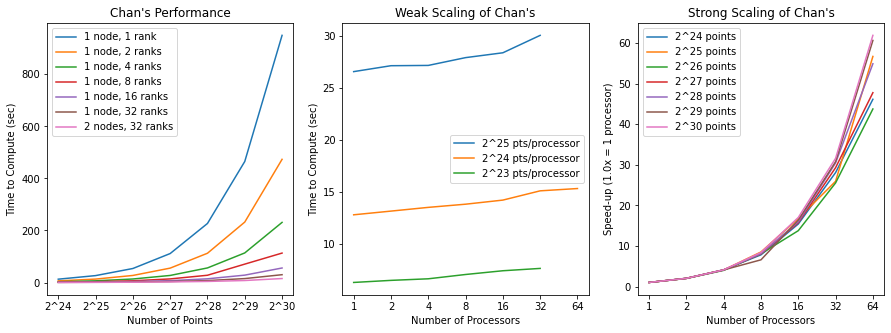

In [79]:
f = open("chan_results.txt", "r")
res = []
for x in f:
    res.append(float(x))
arr = np.array(res).reshape(7,7)

graph('Chan\'s', 'ch_performance.png', arr)

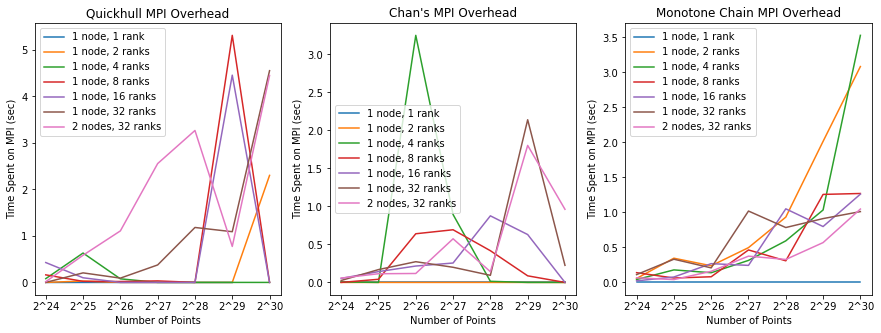

In [89]:
def use_file(ax, filename, nm):
    with open(filename, "r") as f:
        arr = np.array([float(x) for x in f]).reshape(7,7)


        ranks = [2**n for n in range(0,7)]
        pts = [f'2^{x}' for x in range(24,31)]
        pts_exp = [2**x for x in range(24,31)]

        ax.set_xticks(np.arange(arr.shape[0]))
        ax.set_xticklabels(pts)
        ax.set_xlabel("Number of Points")
        ax.set_ylabel("Time Spent on MPI (sec)")
        ax.set_title(f"{nm} MPI Overhead")
        ax.plot(arr)
        rank_labels = [f'1 node, {r} rank{"s" if r != 1 else ""}' for r in ranks]
        rank_labels[-1] = '2 nodes, 32 ranks'
        ax.legend(rank_labels)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
for ax,f,nm in zip(axes, ['quick_overhead.txt', 'chan_overhead.txt', 'mc_overhead.txt'], ['Quickhull', 'Chan\'s', 'Monotone Chain']):
    use_file(ax,f,nm)
    
plt.savefig('overheads.png')